<a href="https://colab.research.google.com/github/abhinavztb/Image_Segmentation_Detecting_Crop_Rows/blob/main/DL_Segmentation_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhinavasthana","key":"a69f16c5b7cc68685f2071e7fd59c3fb"}'}

In [ ]:
 ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c detecting-crop-rows-from-image-data

 44% 12.0M/27.2M [00:00<00:00, 125MB/s]
100% 27.2M/27.2M [00:00<00:00, 210MB/s]


In [ ]:
! unzip detecting-crop-rows-from-image-data.zip -d files

Archive:  detecting-crop-rows-from-image-data.zip
  inflating: files/Images/Images/.ds_store  
  inflating: files/Images/Images/.ipynb_checkpoints/Crop Row Data - prepare dataset-checkpoint.ipynb  
  inflating: files/Images/Images/crop_row_001.jpg  
  inflating: files/Images/Images/crop_row_002.jpg  
  inflating: files/Images/Images/crop_row_003.jpg  
  inflating: files/Images/Images/crop_row_004.jpg  
  inflating: files/Images/Images/crop_row_005.jpg  
  inflating: files/Images/Images/crop_row_006.jpg  
  inflating: files/Images/Images/crop_row_007.jpg  
  inflating: files/Images/Images/crop_row_008.jpg  
  inflating: files/Images/Images/crop_row_009.jpg  
  inflating: files/Images/Images/crop_row_010.jpg  
  inflating: files/Images/Images/crop_row_011.jpg  
  inflating: files/Images/Images/crop_row_012.jpg  
  inflating: files/Images/Images/crop_row_013.jpg  
  inflating: files/Images/Images/crop_row_014.jpg  
  inflating: files/Images/Images/crop_row_015.jpg  
  inflating: files/Ima

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:

def load_and_preprocess_images(ids, image_dir):
    images = []

    for img_id in ids:
        img_id = int(img_id)  # Convert the ID to an integer to remove any decimal points
        img_path = os.path.join(image_dir, f'crop_row_{img_id:03d}.jpg')  # Use string formatting to pad with zeros
        #img_path = os.path.join(image_dir, f'crop_row_{img_id}.jpg')  # Change the file extension if needed
        img = Image.open(img_path)
        #img = img.resize(target_size)
        img_array = np.array(img) / 255.0  # Normalize pixel values between 0 and 1
        images.append(img_array)

    return np.array(images)

def load_train_labels(ids, label_dir):
    labels = []

    for img_id in ids:
        img_id = int(img_id)
        label_path = os.path.join(label_dir, f'crop_row_{img_id:03d}.npy')
        label = np.load(label_path)
        label = label / 255.0
        labels.append(label)

    return np.array(labels)
def rle_encode(mask):
    '''
    mask: numpy array binary mask
    255 - mask
    0 - background
    Returns encoded run length
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]

    return ' '.join(str(x) for x in runs)

In [ ]:
df = pd.read_csv("/content/files/train and test ids.csv", dtype = 'str')
image_dir = '/content/files/Images/Images/'
label_dir = '/content/files/train_labels/train_labels/'
# Load and preprocess the train and test images
train_images = load_and_preprocess_images(df['train_ids'].dropna().values, image_dir)
test_images = load_and_preprocess_images(df['test_ids'].dropna().values, image_dir)
# Load the train labels
train_labels = load_train_labels(df['train_ids'].dropna().values, label_dir)
train_labels = np.mean(train_labels, axis=-1, keepdims=True)

In [ ]:
def generate_predictions(test_ids, model, output, image_dir, threshold):
    results = {}
    for img in test_ids:
        img_id = int(img)
        image_path = os.path.join(image_dir, f'crop_row_{img_id:03d}.jpg')
        image = load_and_preprocess_image(image_path)

        segmentation = model.predict(image)
        segmentation = (segmentation.squeeze() * 255).astype(np.uint8)


        binary_mask = (segmentation / np.max(segmentation) > threshold).astype(np.uint8)
        rle = rle_encode(binary_mask)
        results[img] = rle

    data = [(k, v) for k, v in results.items()]
    results = pd.DataFrame(data, columns=['ids', 'labels'])
    results.to_csv(str(output)+'_results.csv', index=False)

In [ ]:
def unet(input_shape=(240, 320, 3)):
    inputs = layers.Input(input_shape)

    # Contracting path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expanding path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
unet_model = unet()
history = unet_model.fit(train_images, train_labels, batch_size=16, epochs=25, validation_split=0.1)

Epoch 1/25
12/12 [==============================] - 34s 803ms/step - loss: 0.5031 - accuracy: 0.9279 - val_loss: 0.2658 - val_accuracy: 0.9347
Epoch 2/25
12/12 [==============================] - 1s 108ms/step - loss: 0.2534 - accuracy: 0.9334 - val_loss: 0.2446 - val_accuracy: 0.9347
Epoch 3/25
12/12 [==============================] - 1s 107ms/step - loss: 0.2429 - accuracy: 0.9334 - val_loss: 0.2393 - val_accuracy: 0.9347
Epoch 4/25
12/12 [==============================] - 1s 107ms/step - loss: 0.2378 - accuracy: 0.9334 - val_loss: 0.2348 - val_accuracy: 0.9347
Epoch 5/25
12/12 [==============================] - 1s 107ms/step - loss: 0.2339 - accuracy: 0.9334 - val_loss: 0.2335 - val_accuracy: 0.9347
Epoch 6/25
12/12 [==============================] - 1s 107ms/step - loss: 0.2313 - accuracy: 0.9334 - val_loss: 0.2230 - val_accuracy: 0.9347
Epoch 7/25
12/12 [==============================] - 1s 107ms/step - loss: 0.2272 - accuracy: 0.9334 - val_loss: 0.2198 - val_accuracy: 0.9347
Epoch

In [ ]:
import keras
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Input
from keras.models import Model

def build_segnet(input_shape=(240, 320, 3), n_classes=1):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(up4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    conv7 = Conv2D(n_classes, (1, 1), activation='sigmoid')(conv6)

    model = Model(inputs=inputs, outputs=conv7)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build the SegNet model
segnet_model = build_segnet(input_shape=(240, 320, 3), n_classes=1)

# Train the SegNet model
segnet_history = segnet_model.fit(train_images, train_labels, batch_size=16, epochs=25, validation_split=0.1)


Epoch 1/25
12/12 [==============================] - 10s 138ms/step - loss: 0.7192 - accuracy: 0.5794 - val_loss: 0.3973 - val_accuracy: 0.8908
Epoch 2/25
12/12 [==============================] - 1s 103ms/step - loss: 0.6257 - accuracy: 0.7332 - val_loss: 0.3966 - val_accuracy: 0.9298
Epoch 3/25
12/12 [==============================] - 1s 103ms/step - loss: 0.5784 - accuracy: 0.8095 - val_loss: 0.3115 - val_accuracy: 0.9299
Epoch 4/25
12/12 [==============================] - 1s 103ms/step - loss: 0.5307 - accuracy: 0.8639 - val_loss: 0.6707 - val_accuracy: 0.6560
Epoch 5/25
12/12 [==============================] - 1s 104ms/step - loss: 0.4861 - accuracy: 0.8967 - val_loss: 0.5550 - val_accuracy: 0.9347
Epoch 6/25
12/12 [==============================] - 1s 103ms/step - loss: 0.4418 - accuracy: 0.9071 - val_loss: 0.5855 - val_accuracy: 0.9328
Epoch 7/25
12/12 [==============================] - 1s 104ms/step - loss: 0.3974 - accuracy: 0.9174 - val_loss: 0.7618 - val_accuracy: 0.1790
Epoch

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, UpSampling2D, Concatenate, MaxPooling2D

def linknet(input_shape=(320, 240, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv2 = Conv2D(64, (3, 3), padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding='same')(pool1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv4 = Conv2D(128, (3, 3), padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), padding='same')(pool2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv6 = Conv2D(256, (3, 3), padding='same')(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)

    conv7 = Conv2D(512, (3, 3), padding='same')(pool3)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv8 = Conv2D(512, (3, 3), padding='same')(conv7)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    # Decoder
    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Concatenate()([up9, conv6])
    conv9 = Conv2D(256, (3, 3), padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv10 = Conv2D(256, (3, 3), padding='same')(conv9)
    conv10 = BatchNormalization()(conv10)
    conv10 = Activation('relu')(conv10)

    up11 = UpSampling2D(size=(2, 2))(conv10)
    up11 = Concatenate()([up11, conv4])
    conv11 = Conv2D(128, (3, 3), padding='same')(up11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Activation('relu')(conv11)
    conv12 = Conv2D(128, (3, 3), padding='same')(conv11)
    conv12 = BatchNormalization()(conv12)
    conv12 = Activation('relu')(conv12)

    up13 = UpSampling2D(size=(2, 2))(conv12)
    up13 = Concatenate()([up13, conv2])
    conv13 = Conv2D(64, (3, 3), padding='same')(up13)
    conv13 = BatchNormalization()(conv13)
    conv13 = Activation('relu')(conv13)
    conv14 = Conv2D(64, (3, 3), padding='same')(conv13)
    conv14 = BatchNormalization()(conv14)
    conv14 = Activation('relu')(conv14)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv14)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Build the SegNet model
linknet_model = linknet(input_shape=(240, 320, 3))

# Train the SegNet model
linknet_history = linknet_model.fit(train_images, train_labels, batch_size=16, epochs=25, validation_split=0.2)

Epoch 1/25
11/11 [==============================] - 30s 2s/step - loss: 0.5283 - accuracy: 0.7778 - val_loss: 360.0750 - val_accuracy: 0.0681
Epoch 2/25
11/11 [==============================] - 2s 140ms/step - loss: 0.2970 - accuracy: 0.9319 - val_loss: 4409.4473 - val_accuracy: 0.0681
Epoch 3/25
11/11 [==============================] - 2s 140ms/step - loss: 0.2553 - accuracy: 0.9322 - val_loss: 496.0959 - val_accuracy: 0.0687
Epoch 4/25
11/11 [==============================] - 2s 140ms/step - loss: 0.2307 - accuracy: 0.9332 - val_loss: 4.5517 - val_accuracy: 0.1047
Epoch 5/25
11/11 [==============================] - 2s 139ms/step - loss: 0.2156 - accuracy: 0.9336 - val_loss: 1.8522 - val_accuracy: 0.1080
Epoch 6/25
11/11 [==============================] - 2s 139ms/step - loss: 0.2106 - accuracy: 0.9337 - val_loss: 8.4297 - val_accuracy: 0.0978
Epoch 7/25
11/11 [==============================] - 2s 139ms/step - loss: 0.2048 - accuracy: 0.9341 - val_loss: 7.0809 - val_accuracy: 0.0933
E

1/1 [==============================] - 1s 781ms/step


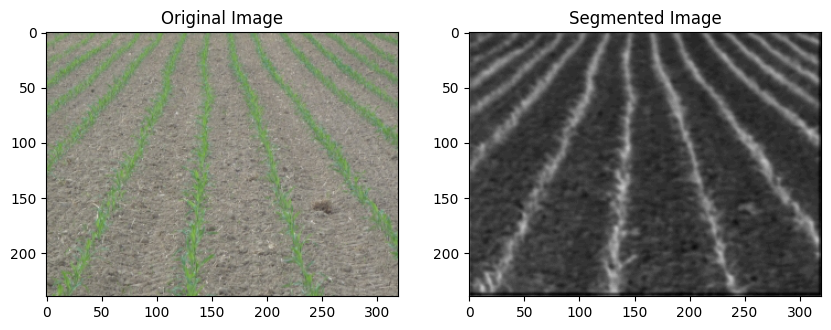

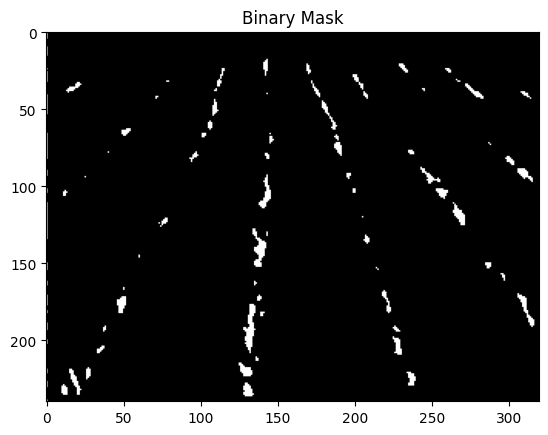

In [ ]:
def segment_image(model, image_path, threshold=0.5):
    # Load and preprocess the image
    img = Image.open(image_path)
    img_array = np.array(img) / 255.0  # Normalize pixel values between 0 and 1
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension

    # Predict the segmentation using the trained model
    segmentation = model.predict(img_array)

    # Remove the batch dimension and convert the segmentation to binary values (0 or 255)
    segmentation = (segmentation.squeeze() * 255).astype(np.uint8)

    # Compute the binary mask using the given threshold
    binary_mask = (segmentation/np.max(segmentation) > threshold).astype(np.uint8)

    # Display the original image and the segmented image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img_array.squeeze())
    ax1.set_title('Original Image')
    ax2.imshow(segmentation, cmap='gray')
    ax2.set_title('Segmented Image')
    plt.show()

    # Display the binary mask
    plt.imshow(binary_mask, cmap='gray')
    plt.title('Binary Mask')
    plt.show()


# Segment the given image using the model
segment_image(unet_model, '/content/files/Images/Images/crop_row_208.jpg', threshold=0.6)


Data Augmentation


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for data augmentation
data_gen_args = dict(rotation_range=15,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)


In [ ]:
# Fit the generator on your data
image_datagen.fit(train_images, seed=42)
mask_datagen.fit(train_labels, seed=42)


In [ ]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)


In [ ]:
# Create generator iterators for training images and masks
train_image_generator = image_datagen.flow(train_images, batch_size=batch_size, seed=42)
train_mask_generator = mask_datagen.flow(train_labels, batch_size=batch_size, seed=42)

# Create generator iterators for validation images and masks
val_image_generator = val_image_datagen.flow(val_images, batch_size=batch_size, seed=42)
val_mask_generator = val_mask_datagen.flow(val_labels, batch_size=batch_size, seed=42)


In [ ]:
# Fit the generators on the training data
image_datagen.fit(train_images, seed=42)
mask_datagen.fit(train_labels, seed=42)

# Create validation ImageDataGenerator (no augmentation)
val_image_datagen = ImageDataGenerator()
val_mask_datagen = ImageDataGenerator()

# Fit the validation generators on the validation data
val_image_datagen.fit(val_images, seed=42)
val_mask_datagen.fit(val_labels, seed=42)


In [ ]:
# Create combined generators for training and validation
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)



In [ ]:
# Train the model using the combined generators
steps_per_epoch = len(train_images) // batch_size
validation_steps = len(val_images) // batch_size
history = unet_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, validation_data=val_generator, validation_steps=validation_steps)


Epoch 1/25
11/11 [==============================] - 5s 346ms/step - loss: 0.2129 - accuracy: 0.9069 - val_loss: 0.2100 - val_accuracy: 0.9418
Epoch 2/25
11/11 [==============================] - 3s 314ms/step - loss: 0.2077 - accuracy: 0.9077 - val_loss: 0.2157 - val_accuracy: 0.9380
Epoch 3/25
11/11 [==============================] - 3s 304ms/step - loss: 0.2134 - accuracy: 0.9066 - val_loss: 0.2114 - val_accuracy: 0.9405
Epoch 4/25
11/11 [==============================] - 3s 306ms/step - loss: 0.2038 - accuracy: 0.9090 - val_loss: 0.2067 - val_accuracy: 0.9406
Epoch 5/25
11/11 [==============================] - 3s 300ms/step - loss: 0.2100 - accuracy: 0.9055 - val_loss: 0.2094 - val_accuracy: 0.9379
Epoch 6/25
11/11 [==============================] - 3s 303ms/step - loss: 0.2008 - accuracy: 0.9097 - val_loss: 0.2077 - val_accuracy: 0.9384
Epoch 7/25
11/11 [==============================] - 3s 309ms/step - loss: 0.2024 - accuracy: 0.9080 - val_loss: 0.2303 - val_accuracy: 0.9374
Epoch 

1/1 [==============================] - 0s 23ms/step


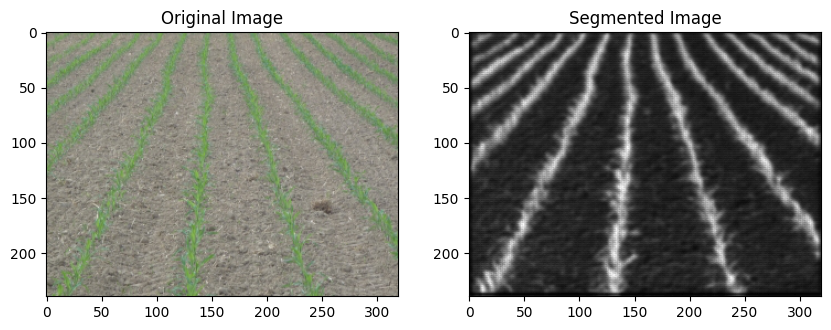

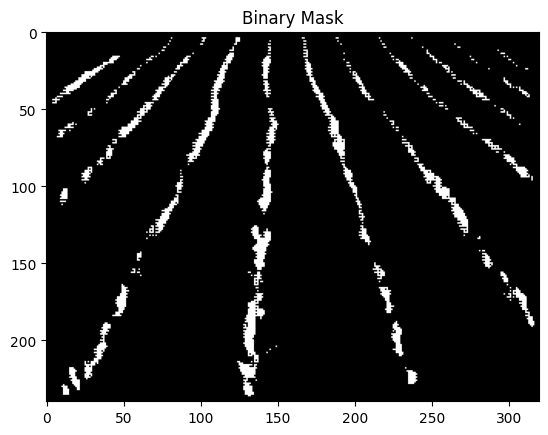

In [ ]:

# Segment the given image using the model
segment_image(unet_model, '/content/files/Images/Images/crop_row_208.jpg', threshold=0.65)

In [ ]:
linknet_history = linknet_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, validation_data=val_generator, validation_steps=validation_steps)


Epoch 1/25
11/11 [==============================] - 5s 352ms/step - loss: 0.1694 - accuracy: 0.9067 - val_loss: 0.2817 - val_accuracy: 0.9408
Epoch 2/25
11/11 [==============================] - 7s 294ms/step - loss: 0.1662 - accuracy: 0.9083 - val_loss: 0.3267 - val_accuracy: 0.9396
Epoch 3/25
11/11 [==============================] - 3s 305ms/step - loss: 0.1685 - accuracy: 0.9069 - val_loss: 0.3143 - val_accuracy: 0.9378
Epoch 4/25
11/11 [==============================] - 3s 305ms/step - loss: 0.1652 - accuracy: 0.9079 - val_loss: 0.3293 - val_accuracy: 0.9386
Epoch 5/25
11/11 [==============================] - 3s 313ms/step - loss: 0.1609 - accuracy: 0.9110 - val_loss: 0.2522 - val_accuracy: 0.9386
Epoch 6/25
11/11 [==============================] - 3s 303ms/step - loss: 0.1610 - accuracy: 0.9092 - val_loss: 0.2867 - val_accuracy: 0.9408
Epoch 7/25
11/11 [==============================] - 3s 303ms/step - loss: 0.1709 - accuracy: 0.9032 - val_loss: 0.2452 - val_accuracy: 0.9380
Epoch 

1/1 [==============================] - 0s 26ms/step


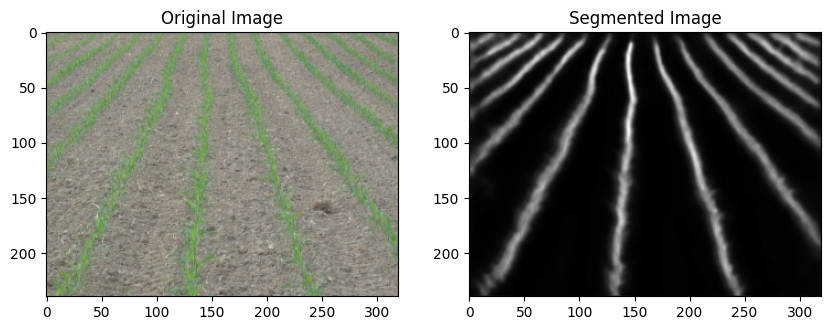

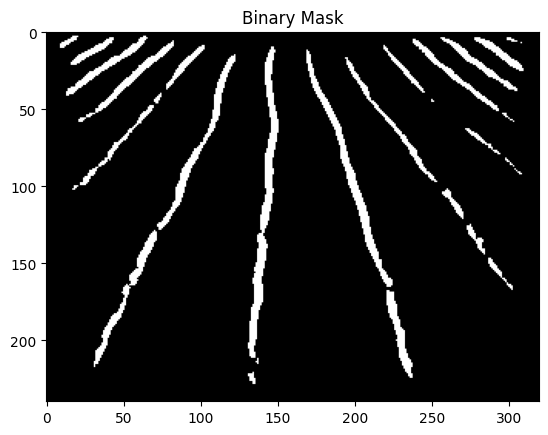

In [ ]:

# Segment the given image using the model
segment_image(linknet_model, '/content/files/Images/Images/crop_row_208.jpg', threshold=0.5)

In [ ]:
segnet_history = segnet_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, validation_data=val_generator, validation_steps=validation_steps)


Epoch 1/25
11/11 [==============================] - 5s 342ms/step - loss: 0.1714 - accuracy: 0.9059 - val_loss: 0.4152 - val_accuracy: 0.9402
Epoch 2/25
11/11 [==============================] - 3s 314ms/step - loss: 0.1714 - accuracy: 0.9076 - val_loss: 0.4006 - val_accuracy: 0.9388
Epoch 3/25
11/11 [==============================] - 3s 308ms/step - loss: 0.1660 - accuracy: 0.9086 - val_loss: 0.3407 - val_accuracy: 0.9387
Epoch 4/25
11/11 [==============================] - 3s 309ms/step - loss: 0.1625 - accuracy: 0.9110 - val_loss: 0.4278 - val_accuracy: 0.9354
Epoch 5/25
11/11 [==============================] - 3s 301ms/step - loss: 0.1678 - accuracy: 0.9062 - val_loss: 0.3372 - val_accuracy: 0.9418
Epoch 6/25
11/11 [==============================] - 3s 306ms/step - loss: 0.1635 - accuracy: 0.9078 - val_loss: 0.2247 - val_accuracy: 0.9385
Epoch 7/25
11/11 [==============================] - 3s 306ms/step - loss: 0.1653 - accuracy: 0.9062 - val_loss: 0.2669 - val_accuracy: 0.9294
Epoch 

1/1 [==============================] - 0s 253ms/step


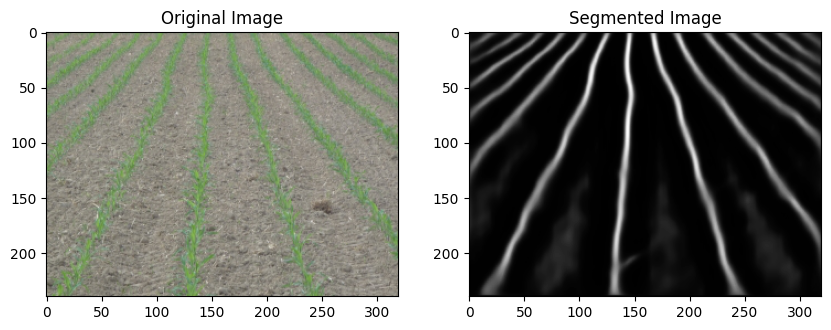

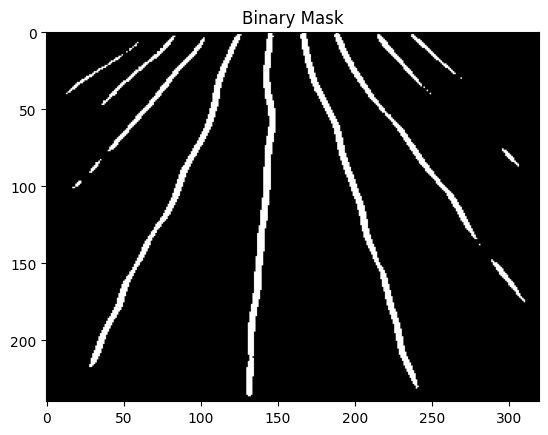

In [ ]:

# Segment the given image using the model
segment_image(segnet_model, '/content/files/Images/Images/crop_row_208.jpg', threshold=0.5)

In [ ]:
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    #img = img.resize(target_size)
    img_array = np.array(img) / 255.0  # Normalize pixel values between 0 and 1
    return np.expand_dims(img_array, axis=0)  # Add a batch dimension

In [ ]:
test_ids = df['test_ids'].dropna().values
generate_predictions(test_ids, unet_model,'unet', '/content/files/Images/Images/',0.6)

1/1 [==============================] - 0s 21ms/step


In [ ]:
generate_predictions(test_ids, linknet_model,'linknet', '/content/files/Images/Images/',0.5)

1/1 [==============================] - 0s 20ms/step


In [ ]:
generate_predictions(test_ids, segnet_model,'segnet', '/content/files/Images/Images/',0.48)

1/1 [==============================] - 0s 21ms/step


In [ ]:
# Calculate IoU score

def IoU_scores(student_labels, solution_labels):
    IoU_scores = []

    for i in range(len(solution_labels)):
        student_array = decode_rle_to_mask(student_labels[i])
        ground_truth_array = decode_rle_to_mask(solution_labels[i])
        overlap = student_array * ground_truth_array # Logical AND
        union = student_array + ground_truth_array # Logical OR
        union[union>1] = 1
        IoU = overlap.sum()/float(union.sum())
        IoU_scores.append(IoU)

    return np.mean(IoU_scores)